<a href="https://colab.research.google.com/github/martintmv-git/RB-IBDM/blob/main/Experiments/Generating%20Masks%20with%20SAM/Language%20Segment-Anything/language_segment_anything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Segment Anything

Language Segment-Anything is an open-source project that combines the power of instance segmentation and text prompts to generate masks for specific objects in images. Built on top of Meta AI's segment-anything, and the GroundingDINO detection model.

## Pip installs

In [1]:
%pip install torch torchvision
%pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 941.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 2.8 MB/s eta 0:00:00
  Cloning https://git

## Before starting

Make sure you are connected to a GPU.

In [1]:
!nvidia-smi

Thu Apr  4 23:12:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Insect Positive Prompt Method (day image)


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:15<00:00, 161MB/s]


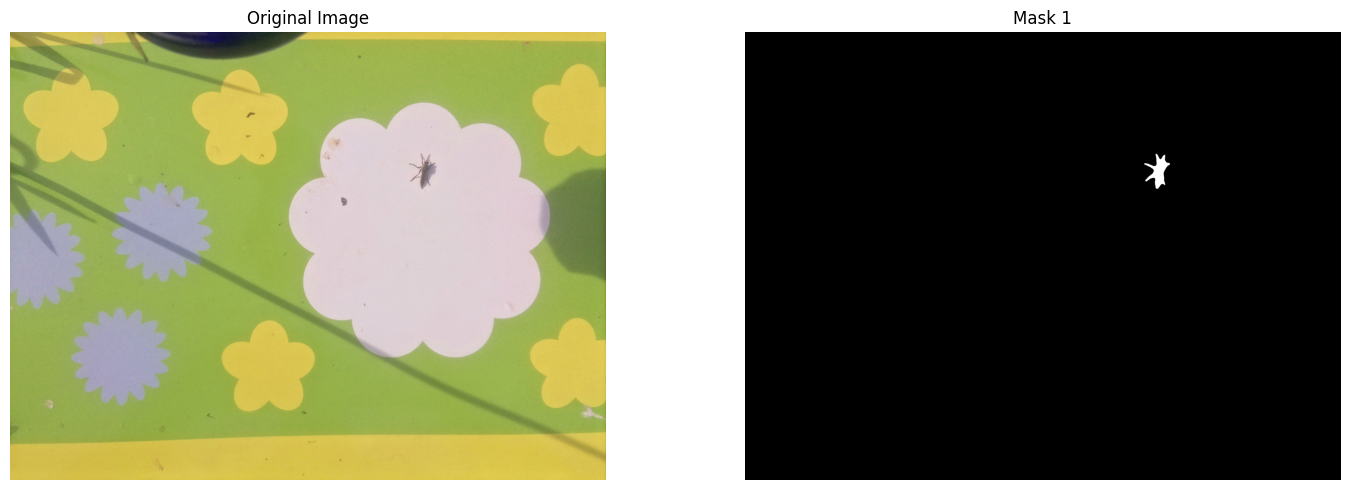

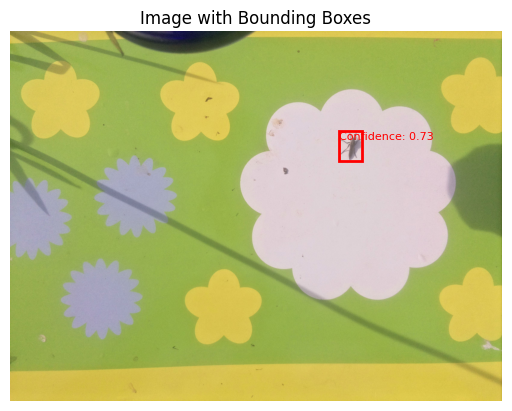

Bounding Boxes:
Box 1: tensor([2192.6294,  663.3716, 2349.1328,  863.4258])

Detected Phrases:
Phrase 1: insects

Confidence:
Logit 1: 0.7300127148628235


In [4]:
image = "/content/drive/MyDrive/rb-ibdm-sampledata/flower-day-3.jpeg"
text_prompt = "insects"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

## Insect Negative Prompt Method (day image)

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


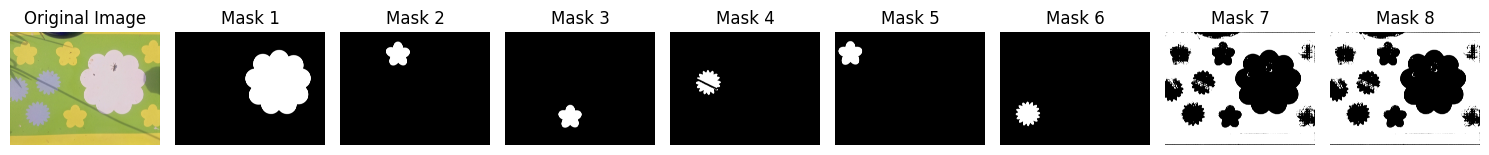

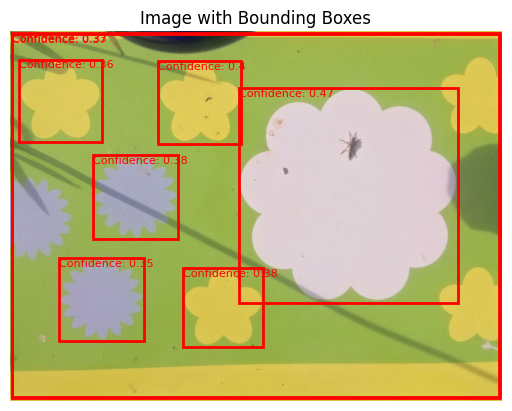

Bounding Boxes:
Box 1: tensor([1524.2812,  376.3112, 2985.0889, 1808.7355])
Box 2: tensor([ 988.6153,  197.0409, 1539.5430,  748.7603])
Box 3: tensor([1152.4564, 1575.7539, 1688.8121, 2103.3809])
Box 4: tensor([ 550.0374,  820.8433, 1121.3931, 1385.4889])
Box 5: tensor([ 62.2736, 187.2036, 610.3006, 733.5855])
Box 6: tensor([ 328.0088, 1508.2614,  892.4169, 2062.7261])
Box 7: tensor([  10.2362,   12.4445, 3265.7415, 2443.4163])
Box 8: tensor([  10.4146,   14.1734, 3262.5825, 2435.7009])

Detected Phrases:
Phrase 1: flowers
Phrase 2: flowers
Phrase 3: flowers
Phrase 4: flowers
Phrase 5: flowers
Phrase 6: flowers
Phrase 7: green background
Phrase 8: flowers

Confidence:
Logit 1: 0.47101083397865295
Logit 2: 0.40094467997550964
Logit 3: 0.3754150867462158
Logit 4: 0.3773471415042877
Logit 5: 0.35671132802963257
Logit 6: 0.3470012843608856
Logit 7: 0.33477771282196045
Logit 8: 0.36936628818511963


In [6]:
image = "/content/drive/MyDrive/rb-ibdm-sampledata/flower-day-3.jpeg"
text_prompt = "flowers, green background, yellow background, shadows"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

## Insect Positive Prompt Method (night image)

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


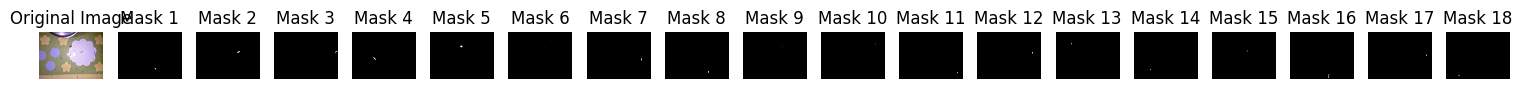

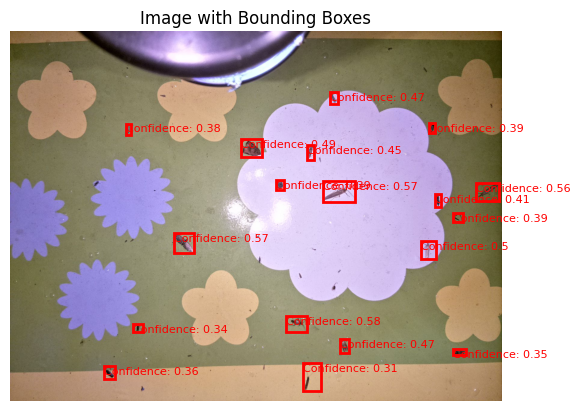

Bounding Boxes:
Box 1: tensor([ 920.8583,  948.1203,  990.0575, 1002.1822])
Box 2: tensor([1044.2665,  498.5967, 1148.8604,  569.0668])
Box 3: tensor([1553.2826,  504.7569, 1630.9584,  564.8317])
Box 4: tensor([546.5029, 671.7628, 612.7822, 738.5343])
Box 5: tensor([770.8417, 359.4871, 838.0009, 419.6054])
Box 6: tensor([1066.0520,  201.0185, 1093.5603,  242.8338])
Box 7: tensor([1370.9990,  699.4605, 1419.1525,  759.3574])
Box 8: tensor([1100.9945, 1023.8696, 1129.6277, 1069.9893])
Box 9: tensor([ 989.2545,  379.8076, 1012.4392,  428.9700])
Box 10: tensor([1397.8208,  303.6912, 1417.6292,  338.6840])
Box 11: tensor([1476.2410, 1057.4983, 1519.3021, 1079.3479])
Box 12: tensor([1415.0061,  540.9054, 1435.3074,  584.1113])
Box 13: tensor([386.4548, 306.5749, 401.3679, 343.6120])
Box 14: tensor([ 410.5524,  974.8875,  441.9557, 1001.8829])
Box 15: tensor([884.8651, 495.9360, 913.0405, 529.3638])
Box 16: tensor([ 977.7838, 1104.3983, 1036.6195, 1197.9135])
Box 17: tensor([1476.5203,  603.6

In [8]:
image = "/content/drive/MyDrive/rb-ibdm-sampledata/flower-night-1.jpg"
text_prompt = "insects"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

## Insect Negative Prompt Method (night image)

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


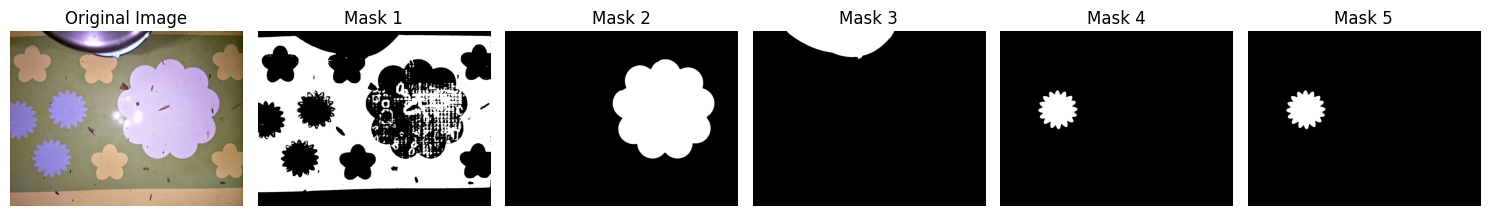

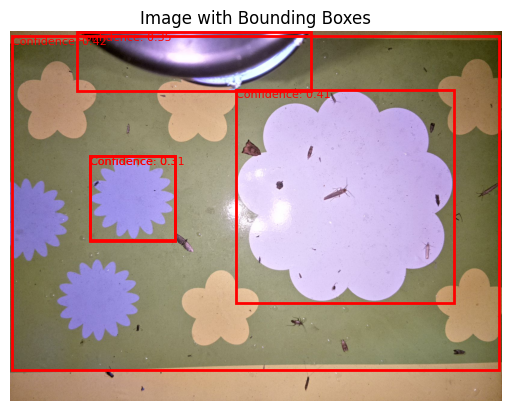

Bounding Boxes:
Box 1: tensor([   7.6906,   16.1829, 1628.9551, 1128.2389])
Box 2: tensor([ 752.8157,  193.3779, 1479.3130,  906.2625])
Box 3: tensor([ 224.1189,    1.2195, 1004.4538,  198.4056])
Box 4: tensor([266.1125, 413.4634, 550.0124, 696.7269])
Box 5: tensor([266.8158, 414.2018, 549.7464, 696.4753])

Detected Phrases:
Phrase 1: flowers
Phrase 2: flowers
Phrase 3: lamp
Phrase 4: flowers
Phrase 5: blue flowers

Confidence:
Logit 1: 0.424180805683136
Logit 2: 0.4087221324443817
Logit 3: 0.349330335855484
Logit 4: 0.3009675145149231
Logit 5: 0.3085830807685852


In [15]:
image = "/content/drive/MyDrive/rb-ibdm-sampledata/flower-night-1.jpg"
text_prompt = "flowers, green, yellow flowers, blue flowers, lamp, shadows"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()